# ISEL - CSM 
## Semestre 2021/22
# <br>
###  <center> 4º Trabalho Prático </center>
# </br>


Trabalho realizado por:
- António Luís Ferreia, número <b> 47500 </b>
- Tomás Gomes, número <b> 48614 </b>

#### Imports

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from time import time
import os
import re
from tabulate import tabulate
from IPython.display import Markdown as md

In [5]:
np.arange(25,875,25)

array([ 25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325,
       350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650,
       675, 700, 725, 750, 775, 800, 825, 850])

### Taxa de Compressão 
- Tc = Taxa de Compressão
- Io = Imagem original
- Ic = Imagem comprimida

$Tc = \frac{Io}{Ic}$

In [2]:
def taxa_compressao(pathName, ext, binaryFile):
    size_ini = os.path.getsize(pathName+ext) 
    size_end = os.path.getsize(binaryFile) 
    tx_comp = 1.0* size_ini / size_end  
    return tx_comp

###  SNR 
- Ps = Potência do sinal
- Pe = Potênica do erro

$SNR = 10 \log_{10} \frac{Ps}{Pe}$

In [3]:
def SNR(x, y): 
    pSinal = np.sum((x*1.0)**2)/len(x)
    erro = x-y 
    pErro = np.sum((erro)**2)/len(erro) 
    SNR = 10*np.log10(pSinal/pErro)
    return SNR

###  Entropia 
$Entropia = \sum_{k=1}^{N} probs(k)\log_{2} probs(k)$

In [4]:
def probabilidades(img):
    #dicionário onde vai armazenar as probabilidades
    dic = {}
    
    # tamanho total da imagem
    total = img.shape[0] * img.shape[1]
    
    #Função auxiliar que conta a ocorrencia de cada símbolo
    def recorrencia(simb):
        if simb in dic.keys():
            dic[simb] += 1 
        else:
            dic[simb] = 1 
            
    #Função auxiliar que passa a probabilidade para percentagem
    def cal_probabilidade(simb):
        dic[simb] = dic[simb]/total
    [recorrencia(simb) for simb in img.flatten()]
    [cal_probabilidade(simb) for simb in dic] 
    return dic

In [5]:
def entropia(probs):
    #calculo da entropia
    resultado = [probs[i] * np.log2(probs[i]) for i in probs]
    resultado = np.sum(resultado)
    return -resultado

###  Energia média por pixel

In [6]:
def energia_media_pixel(frame):
    resultado = np.sum(frame**2) / (frame.shape[0] * frame.shape[1])
    return resultado

###  Cria video

In [7]:
def criar_video(num_frames, dimY, dimX, nome):
    ext    = '.tiff'
    video  = np.empty( ( num_frames, dimY, dimX ) )
    for n in range(1,num_frames+1):
        img = cv2.imread('orig_' + nome + '/' + nome + '_' + str(n) + ext, 0 )
        video[n - 1] = img
    return video, nome

In [8]:
video_bola, nome = criar_video(11, 240, 352, 'bola')
video_car, nome = criar_video(11, 256, 256, 'car')

## <center> 1º Codificador </center>
- Este primeiro codificador é um modelo mais simplista, onde irá codificadar todas as imagens usando o codificador JPEG

##### 1.1 Codifica

In [9]:
def codifica_1(video, nome):

    #Criaçao de tabela para preencher com os varios parametros pedidos no enunciado
    resultados = {'taxa_compressao'     : [],
                  'SNR'                 : [],
                  'entropia'            : [],
                  'energia_media_pixel' : [],
                  'tempo_comp'          : [],
                  'tempo_decomp'        : []}

    #for loop para correr o array dos frames, Frame a Frame (intraframe)
    for i in range(len(video)):

        #pelo path, obter frame a frame
        pathIni  = 'orig_' + nome + '/' + nome + '_' + str(i+1)
        ext      = '.tiff'
        frame    = video[i]
        pathComp = 'cod_1_' + nome + '/' + nome + '_c1_' + str(i+1) + '.jpg'
        
        #medir o tempo de compressao
        t0 = time()
        cv2.imwrite( pathComp, frame, (cv2.IMWRITE_JPEG_QUALITY, 50))
        t1 = time()

        # atribuir os tempos de compressao na tabela
        resultados['tempo_comp'].append(round(t1-t0, 6))

        # medir taxa compressao
        taxa = taxa_compressao(pathIni, ext, pathComp)
        resultados['taxa_compressao'].append(round(taxa, 3))

        #passar a imagem para pixeis
        frame_a_trans = cv2.imread(pathComp, 0)

        # medir entropia de cada uma das frames
        _entropia = entropia(probabilidades(frame_a_trans))
        resultados['entropia'].append(round(_entropia, 3))

        # medir a energia média por pixel de cada uma das frames
        resultados['energia_media_pixel'].append(round(energia_media_pixel(frame_a_trans), 2))
    return resultados

##### 1.1 Descodifica

In [10]:
def descodifica_1(resultados, nome):
    for i in range(len(resultados['taxa_compressao'])):
        #medir tempos de decod
        t0      = time()
        img_cod = cv2.imread( 'cod_1_' + nome + '/' + nome + '_c1_' + str( i + 1 ) + '.jpg' )
        cv2.imwrite( 'decod_1_' + nome + '/' + nome +'_dc1_' + str( i + 1 ) + '.tiff', img_cod )
        t1      = time()
        
        #ler imagens originais
        im_original = cv2.imread( 'orig_' + nome + '/' + nome +'_' + str(i+1)    + '.tiff', 0)
        
        #ler imagens descodificadas
        im_decod    = cv2.imread( 'decod_1_' + nome + '/'+ nome +'_dc1_' + str(i+1) + '.tiff', 0)
        
        #medir SNR 
        snr = SNR(im_original, im_decod)
        resultados['SNR'].append(round(snr, 2)) 
        
        # tempo de descompressao
        resultados['tempo_decomp'].append(round(t1 - t0, 6))
    return resultados

## <center> 2º Codificador </center>
- Este segundo codicador apenas usa o JPEG codec para a primeira frame (I-frame).
- Todas as outras frames são do tipo inter (P-frame).

Uma $\textit{interframe}$ é uma frame cálculada através da diferença da frame a codificar e a frame inical.

##### 2.1 Codificação

In [11]:
def codifica_2(video, nome):
    size = len(video)
    QUALIDADE = 50
    
    resultados = {'taxa_compressao'     : [],
                  'SNR'                 : [],
                  'entropia'            : [],
                  'energia_media_pixel' : [],
                  'tempo_comp'          : [],
                  'tempo_decomp'        : []}
    
    for i in range(size):
        
        #pelo path, obter frame a frame
        pathIni  = 'orig_' + nome + '/' + nome + '_' + str(i+1)
        ext      = '.tiff'
        frame    = video[i]
        pathComp = 'cod_2_' + nome + '/' + nome + '_c2_' + str(i+1) + '.jpg'
        
        t0 = 0
        t1 = 0
        
        # codifica a primeira frame sendo ela do tipo I (intraframe) 
        if(i == 0):
            t0 = time()
            cv2.imwrite( pathComp, frame, (cv2.IMWRITE_JPEG_QUALITY, QUALIDADE))
            t1 = time()
            frame_transmitida = cv2.imread(pathComp, 0)
            # medir entropia da frame I
            ent = entropia(probabilidades(frame_transmitida))
            resultados['entropia'].append(round(ent,3))
        
        # codifica todas as frames sendo elas do tipo P (interframe)
        else: 
            t0 = time()
            frameI = video[0]
            frameP = frame - frameI
            frameP = (frameP+255)/2
            cv2.imwrite( pathComp, frameP, (cv2.IMWRITE_JPEG_QUALITY, QUALIDADE))
            t1 = time()
            
            #calcula a entropia de cada frame
            ent = entropia(probabilidades(frameP))
            resultados['entropia'].append(round(ent,3))
            
        # taxa compressao
        taxa = taxa_compressao(pathIni, ext, pathComp)
        resultados['taxa_compressao'].append(round(taxa,3))
        # energia média por pixel de cada uma das frames
        frame_a_trans = cv2.imread(pathComp, 0)
        resultados['energia_media_pixel'].append(round(energia_media_pixel(frame_a_trans),2))
        # tempo de compressao
        resultados['tempo_comp'].append(round(t1-t0,7))
        
    return resultados

##### 2.2 Descodificação

In [12]:
def descodifica_2(resultados, nome):
    frameI = cv2.imread( 'cod_2_' + nome +'/' + nome + '_c2_1.jpg', 0 )
    
    for i in range(len(resultados['taxa_compressao'])):
        t0 = 0
        t1 = 0
        img_original = cv2.imread( 'orig_'  + nome + '/' + nome + '_' + str(i+1) + '.tiff', 0 )
        img_cod     = cv2.imread( 'cod_2_' + nome + '/' + nome + '_c2_' + str(i+1) +  '.jpg', 0 )
        
        if i == 0:
            t0 = time()
            cv2.imwrite( 'decod_2_' + nome + '/' + nome + '_dc2_' + str( i + 1 ) + '.tiff', img_cod )
            t1 = time()
            
        else:
            t0 = time()
            dif    = img_cod
            dif    = ( dif * 2.0 ) - 255
            frame  = dif + frameI
            cv2.imwrite('decod_2_' + nome + '/' + nome + '_dc2_' + str(i + 1) + '.tiff', frame )
            t1 = time()
        img_decod = cv2.imread( 'decod_2_' + nome + '/' + nome + '_dc2_' + str(i+1) + '.tiff', 0 )
        # medir SNR
        snr = SNR(img_original,img_decod)
        resultados['SNR'].append(round(snr,2))
        # tempo de descompressao
        resultados['tempo_decomp'].append(round(t1-t0,7))
        
    return resultados

## <center> 3º Codificador </center>
- Por fim, este codificador acrescenta ao codicador 2 a $\textit{compensação de movimento}$.

Compensação de movimento consiste em:
- cálcular o vetor movimento
- aplicar o vetor
- cálcular o erro entre a frame e a predição atual

#### Métodos auxiliares:

##### Erro Absoluto Médio

<img style="float: center;" src="eam.jpg">

In [13]:
def medir_EAM(bloco1, bloco2):
    bloco = np.abs( bloco1 * 1.0 - bloco2 * 1.0 )
    return np.sum( bloco ) / ( bloco1.shape[0] * bloco1.shape[1] )

##### Get Janela Pretendida
- Este método recebe a intra fame, linha do bloco e a coluna do bloco
- Retornando uma janela (um pedaço da intraframe)

In [14]:
def get_janela_pretendida(iframe,idx_l,idx_c):
    #altura
    pixel_h = len( iframe )     
    #largura
    pixel_w = len( iframe[0] ) 
    
    # indice da linha onde vai começar a janela de pesquisa
    idx_start_linha = int(max(idx_l*16-15,0))
    # indice da coluna onde vai começar a janela de pesquisa
    idx_start_coluna = int(max(idx_c*16-15,0))
   
    # indice da linha onde vai acabar a janela de pesquisa
    idx_finish_linha = int(min(idx_l*16+15+16,pixel_h))
    # indice da coluna onde vai acabar a janela de pesquisa
    idx_finish_coluna = int(min(idx_c*16+15+16, pixel_w)) 
    
    janela = np.zeros((idx_finish_linha - idx_start_linha, idx_finish_coluna - idx_start_coluna), dtype=np.uint8)
    
    for i in range(idx_start_linha, idx_finish_linha):
        for j in range(idx_start_coluna, idx_finish_coluna):
            janela[i-idx_start_linha][j-idx_start_coluna] = iframe[i][j]
    
    return janela

##### Full search
- A função full_search realiza uma pesquisa da compensação de movimento, através da medições sucessivas do Erro Médio Absoluto.

In [15]:
def full_search(bloco, iframe, idx_l, idx_c):
    # coordenadas de blocos, e não de pixeis
    max_pixel_w = int(iframe.shape[1] / 16) - 1 
    
    janela = get_janela_pretendida(iframe, idx_l, idx_c)
    best_i = 0
    best_j = 0
    
    best_eam = float('inf')
    bloco_i  = []
    
    # full search na janela de pesquisa
    for i in range(len(janela) - 16):
        for j in range(len(janela[i]) - 16):
            
            bloco_janela = np.array(janela[i:i+16, j:j+16], dtype = np.uint8)
            eam = medir_EAM(bloco, bloco_janela)
            if eam < best_eam:
                best_eam = eam
                best_i   = i
                best_j   = j
                bloco_i  = bloco_janela
                
    vetor = (None, None)
    # coluna esquerda
    if(idx_c == 0):
        # canto superior esquerdo
        if(idx_l == 0): 
            vetor = (best_i, best_j)
        # restante coluna esquerda    
        else:  
            vetor = (best_i - 15, best_j)
    # coluna direita        
    elif(idx_c == max_pixel_w): 
         # canto superior direito
        if(idx_l == 0): 
            vetor = (best_i, best_j - 15)
        # restante coluna direita    
        else: 
            vetor = (best_i - 15, best_j - 15)
    # linha de cima       
    elif(idx_l == 0):
        # exceto os cantos
        if(idx_c != 0 and idx_c != max_pixel_w): 
            vetor = (best_i, best_j - 15)
    # interior
    else: 
        vetor = (best_i - 15, best_j - 15)
    
    return bloco_i, vetor

##### Get Macro Bloco
- Este método limita-se a retornar um array de blocos de 16x16.
- Os blocos são respetivamente a Imagem divida.

In [16]:
def get_macro_blocks(img, divide = 16):
    # nBlocos = pixeis/64
    nBlocos = int( img.shape[0] * img.shape[1] / ( divide ** 2 ) )     
    # criar um array com nBlocos entradas de 16x16
    blocos  = np.empty( [ nBlocos, divide, divide ], dtype = np.uint8 ) 
    idx   = 0
    for i in range(0, img.shape[0], divide):
        for j in range(0, img.shape[1], divide):
            bloco = img[i : i + divide, j : j + divide]
            blocos[idx] = bloco
            idx += 1
            
    return blocos

##### Reconstroi
- Já este método consite em fazer o inverso do get_macro_blocks.
- Agrupa os blocos 16x16 para formar a imagem.

In [17]:
def reconstroi(blocos, dimImagem):
    imagem = np.zeros((dimImagem[0], dimImagem[1]), dtype = np.uint8)
    idx   = 0
    for i in range(0, dimImagem[0],16):         
        for j in range(0, dimImagem[1],16):
            imagem[i: i+16, j: j+16] = blocos[idx]
            idx += 1 
    return imagem

##### Set frame predita
Método que construi uma frame_predita a partir dos blocos da frame a codificar.

In [18]:
def set_frame_predita(blocos, iframe):
    frame = np.zeros((blocos.shape[0], 16, 16), dtype = np.uint8)
    frame = reconstroi(frame, iframe.shape)
    vetores = []
    
    for idx in range( len( blocos ) ):
        bloco = blocos[idx]
        #número inteiro ignorando o decimal
        i = idx // (int(iframe.shape[1]/16)) 
        #resto da divisão inteira
        j = idx %  (int(iframe.shape[1]/16))
        
        bloco_i, vetor = full_search(bloco, iframe, i, j)
        
        vetores.append(vetor)
        
        frame[(i * 16):(i * 16) + 16, (j * 16) : (j * 16) + 16] = bloco_i
    
    return frame, vetores

##### Get frame predita
Método que retorna a frame predita a partir da intraframe e vetores.

In [19]:
def get_frame_predita(iframe, vetores):
    # cria um novo array vazio do mesmo tipo do iframe
    predita = np.empty_like( iframe, dtype = np.uint8 )
    idx = 0 
    #analisando a iframe por blocosde 16x16
    for i in range(int(iframe.shape[0] / 16)):
        for j in range(int(iframe.shape[1] / 16)):
            vetor     = vetores[idx]
            #bloco reresulta de iframe + vetor 
            bloco = iframe[(i * 16) + vetor[0] : (i * 16) + vetor[0] + 16, (j * 16) + vetor[1] : (j * 16) + vetor[1] + 16]
            #predita resulta da junção de todos os blocos
            predita[(i * 16) : (i * 16) + 16, (j * 16) : (j * 16) + 16] = bloco
            idx += 1
            
    return predita

##### 3.1 Codificação

In [20]:
def codifica_3(video, nome):
    
    resultados = {'taxa_compressao'     : [],
                  'SNR'                 : [],
                  'entropia'            : [],
                  'energia_media_pixel' : [],
                  'tempo_comp'          : [],
                  'tempo_decomp'        : []}
        
    
    num_frames_p = len(video - 1)
    nBlocos      = int( video[0].shape[0] * video[0].shape[1] / ( 16 ** 2 ) )
    
    vetores = np.zeros((num_frames_p, nBlocos, 2), dtype = int)
    
    for i in range(len(video)):
        
        #pelo path, obter frame a frame
        pathIni  = 'orig_' + nome + '/' + nome + '_' + str(i+1)
        ext      = '.tiff'
        frame    = video[i]
        pathComp = 'cod_3_' + nome + '/' + nome + '_c3_' + str(i+1) + '.jpg'
        ent = 0
        
        t0 = 0
        t1 = 0
        QUALIDADE = 50
        
        # codificar a primeira frame como sendo uma frame I
        if(i == 0):
            t0 = time()
            cv2.imwrite( pathComp, frame, (cv2.IMWRITE_JPEG_QUALITY, QUALIDADE))
            t1 = time()
            
            frame_transmitida = cv2.imread(pathComp, 0)
            
            # medir entropia da frame I
            ent = entropia(probabilidades(frame_transmitida))
            resultados['entropia'].append( round( ent, 3 ) )
            
        else:
            t0 = time()
            frameI = video[0]
            blocos = get_macro_blocks(frame)
            frame_predita, vetores_i = set_frame_predita(blocos, frameI)
            vetores[i - 1] = vetores_i
            
            transmitir = ((frame - frame_predita) + 255) / 2 # para dar tons de cinzento
            cv2.imwrite(pathComp, transmitir, ( cv2.IMWRITE_JPEG_QUALITY, QUALIDADE ) )
            t1 = time()
            
            #calcula a entropia de cada frame
            ent = entropia(probabilidades(transmitir))
            resultados['entropia'].append(round(ent,3))
            
        # taxa compressao
        taxa = taxa_compressao(pathIni, ext, pathComp)
        resultados['taxa_compressao'].append(round(taxa,3))
        # energia média por pixel de cada uma das frames
        frame_a_trans = cv2.imread(pathComp, 0)
        resultados['energia_media_pixel'].append(round(energia_media_pixel(frame_a_trans),2))
        # tempo de compressao
        resultados['tempo_comp'].append(round(t1-t0,7))
        
    return resultados, vetores

##### 3.2 Descodificação

In [21]:
def descodifica_3(resultados, vetores, nome):
    
    frameI = cv2.imread( 'cod_3_' + nome +'/' + nome + '_c3_1.jpg', 0 )
    
    for i in range( len( resultados['taxa_compressao'] ) ):
        
        t0 = 0
        t1 = 0
        img_original = cv2.imread( 'orig_'  + nome + '/' + nome + '_' + str(i+1) + '.tiff', 0 )
        img_cod     = cv2.imread( 'cod_3_' + nome + '/' + nome + '_c3_' + str(i+1) +  '.jpg', 0 )
        
        if i == 0:
            t0 = time()
            cv2.imwrite( 'decod_3_' + nome + '/' + nome + '_dc3_' + str( i + 1 ) + '.tiff', img_cod )
            t1 = time()
            
        else:
            t0 = time()
            vetores_i = vetores[i - 1]
            
            # cod = F - Pred <=> F = cod + Pred <=> F = cod + (get_predita(iframe, vetores))
            predita   = get_frame_predita( frameI, vetores_i )
            erro      = ( img_cod * 2.0 ) - 255
            frame     = erro + predita
            cv2.imwrite( 'decod_3_' + nome + '/' + nome + '_dc3_' + str( i + 1 ) + '.tiff', frame )
            t1 = time()
            
         
        img_decod = cv2.imread( 'decod_3_' + nome + '/' + nome + '_dc3_' + str(i+1) + '.tiff', 0 )
        # medir SNR
        snr = SNR( img_original, img_decod )
        resultados['SNR'].append( round( snr, 2 ) )
        
        # tempo de descompressao
        resultados['tempo_decomp'].append( round( t1 - t0, 7 ) )
        
    return resultados

***

### <center> Testes </center>

<center> Nesta secção aplicamos as funções acima implementadas às imagens fornecidas.</center>

| Nomeadamente: |
| --- |
| Codifica e Descodifica 1 |
| Codifica e Descodifica 2 |
| Codifica e Descodifica 3 |

***

##### Car

In [22]:
teste_car_1 = codifica_1(video_car,'car')
resultado_car_1 = descodifica_1(teste_car_1,'car')

In [23]:
teste_car_2 = codifica_2(video_car,'car')
resultado_car_2 = descodifica_2(teste_car_2,'car')

In [24]:
teste_car_3, vetores_car = codifica_3(video_car,'car')
resultado_car_3 = descodifica_3(teste_car_3,vetores_car,'car')

##### Bola

In [25]:
teste_bola_1 = codifica_1(video_bola,'bola')
resultado_bola_1 = descodifica_1(teste_bola_1,'bola')

In [26]:
teste_bola_2 = codifica_2(video_bola,'bola')
resultado_bola_2 = descodifica_2(teste_bola_2,'bola')

In [27]:
teste_bola_3, vetores_bola  = codifica_3(video_bola, 'bola')
resultado_bola_3 = descodifica_3(teste_bola_3, vetores_bola, 'bola') 

***

### <center> Análise de resultados </center>

***

In [28]:
frames = np.arange(0,11)

##### 1º Codificação

- Taxa de compressão

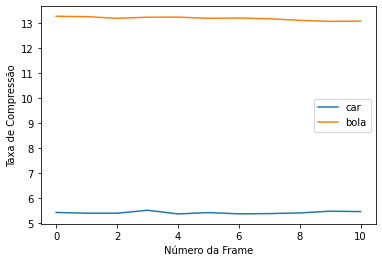

In [29]:
tx_cp_car1 = resultado_car_1['taxa_compressao']
tx_cp_bola1 = resultado_bola_1['taxa_compressao']
plt.plot( frames, tx_cp_car1, label = 'car')
plt.plot( frames, tx_cp_bola1, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("Taxa de Compressão")
plt.show()

- SNR

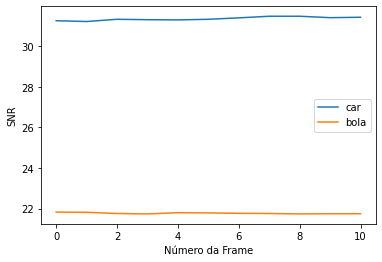

In [30]:
snr_car1 = resultado_car_1['SNR']
snr_bola1 = resultado_bola_1['SNR']
plt.plot( frames, snr_car1, label = 'car')
plt.plot( frames, snr_bola1, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("SNR")
plt.show()

- Entropia

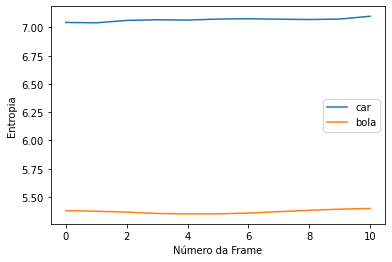

In [31]:
ent_car1 = resultado_car_1['entropia']
ent_bola1 = resultado_bola_1['entropia']
plt.plot( frames, ent_car1, label = 'car')
plt.plot( frames, ent_bola1, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("Entropia")
plt.show()

- Energia média por pixel

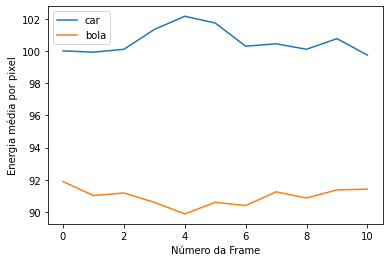

In [32]:
emp_car1 = resultado_car_1['energia_media_pixel']
emp_bola1 = resultado_bola_1['energia_media_pixel']
plt.plot( frames, emp_car1, label = 'car')
plt.plot( frames, emp_bola1, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("Energia média por pixel")
plt.show()

- Tempo de Compressão

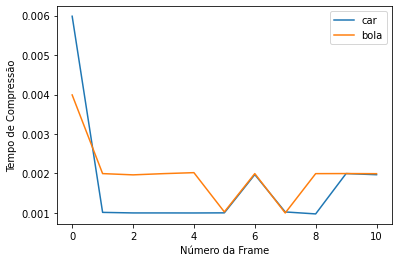

In [33]:
tc_car1 = resultado_car_1['tempo_comp']
tc_bola1 = resultado_bola_1['tempo_comp']
plt.plot( frames, tc_car1, label = 'car')
plt.plot( frames, tc_bola1, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("Tempo de Compressão")
plt.show()

- Tempo de Decompressão

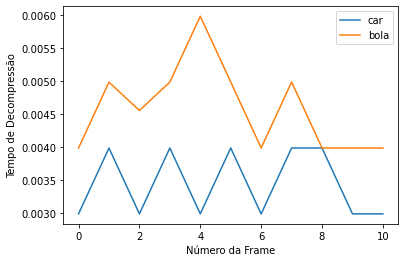

In [34]:
td_car1 = resultado_car_1['tempo_decomp']
td_bola1 = resultado_bola_1['tempo_decomp']
plt.plot( frames, td_car1, label = 'car')
plt.plot( frames, td_bola1, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("Tempo de Decompressão")
plt.show()

##### 2º Codificação

- Taxa de compressão

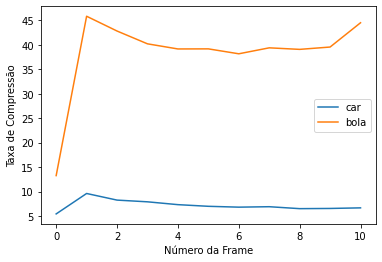

In [35]:
tx_cp_car2 = resultado_car_2['taxa_compressao']
tx_cp_bola2 = resultado_bola_2['taxa_compressao']
plt.plot( frames, tx_cp_car2, label = 'car')
plt.plot( frames, tx_cp_bola2, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("Taxa de Compressão")
plt.show()

- SNR

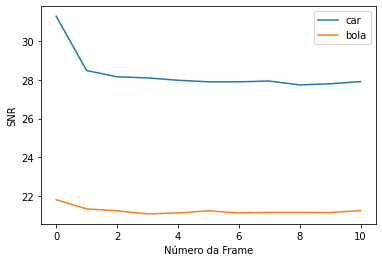

In [36]:
snr_car2 = resultado_car_2['SNR']
snr_bola2 = resultado_bola_2['SNR']
plt.plot( frames, snr_car2, label = 'car')
plt.plot( frames, snr_bola2, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("SNR")
plt.show()

- Entropia

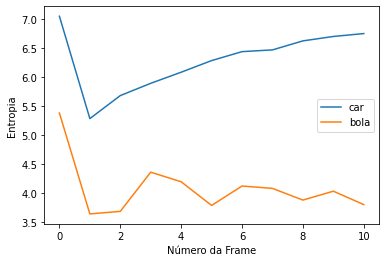

In [37]:
ent_car2 = resultado_car_2['entropia']
ent_bola2 = resultado_bola_2['entropia']
plt.plot( frames, ent_car2, label = 'car')
plt.plot( frames, ent_bola2, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("Entropia")
plt.show()

- Energia média por pixel

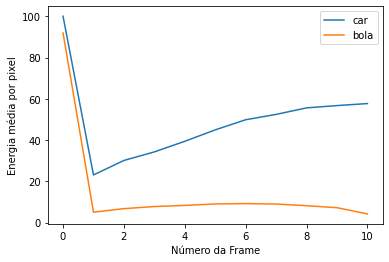

In [38]:
emp_car2 = resultado_car_2['energia_media_pixel']
emp_bola2 = resultado_bola_2['energia_media_pixel']
plt.plot( frames, emp_car2, label = 'car')
plt.plot( frames, emp_bola2, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("Energia média por pixel")
plt.show()

- Tempo de Compressão

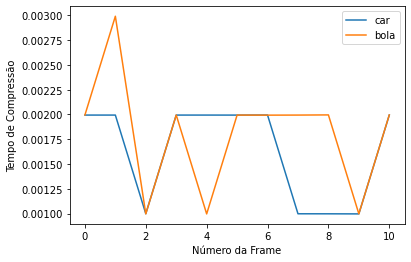

In [39]:
tc_car2 = resultado_car_2['tempo_comp']
tc_bola2 = resultado_bola_2['tempo_comp']
plt.plot( frames, tc_car2, label = 'car')
plt.plot( frames, tc_bola2, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("Tempo de Compressão")
plt.show()

- Tempo de Decompressão

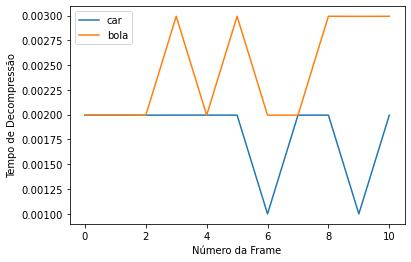

In [40]:
td_car2 = resultado_car_2['tempo_decomp']
td_bola2 = resultado_bola_2['tempo_decomp']
plt.plot( frames, td_car2, label = 'car')
plt.plot( frames, td_bola2, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("Tempo de Decompressão")
plt.show()

##### 3º Codificação

- Taxa de compressão

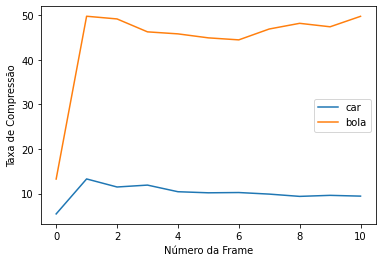

In [41]:
tx_cp_car3 = resultado_car_3['taxa_compressao']
tx_cp_bola3 = resultado_bola_3['taxa_compressao']
plt.plot( frames, tx_cp_car3, label = 'car')
plt.plot( frames, tx_cp_bola3, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("Taxa de Compressão")
plt.show()

- SNR

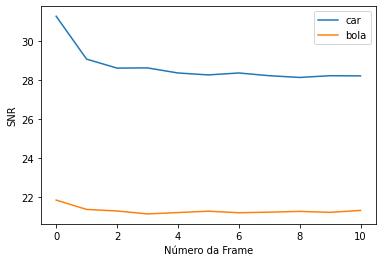

In [42]:
snr_car3 = resultado_car_3['SNR']
snr_bola3 = resultado_bola_3['SNR']
plt.plot( frames, snr_car3, label = 'car')
plt.plot( frames, snr_bola3, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("SNR")
plt.show()

- Entropia

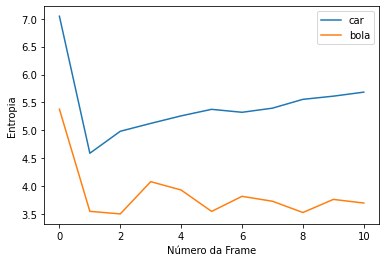

In [43]:
ent_car3 = resultado_car_3['entropia']
ent_bola3 = resultado_bola_3['entropia']
plt.plot( frames, ent_car3, label = 'car')
plt.plot( frames, ent_bola3, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("Entropia")
plt.show()

- Energia média por pixel

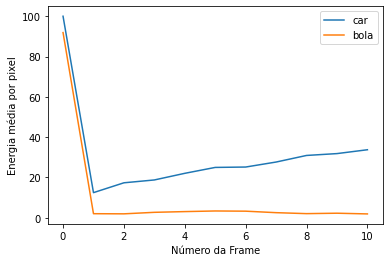

In [44]:
emp_car3 = resultado_car_3['energia_media_pixel']
emp_bola3 = resultado_bola_3['energia_media_pixel']
plt.plot( frames, emp_car3, label = 'car')
plt.plot( frames, emp_bola3, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("Energia média por pixel")
plt.show()

- Tempo de Compressão

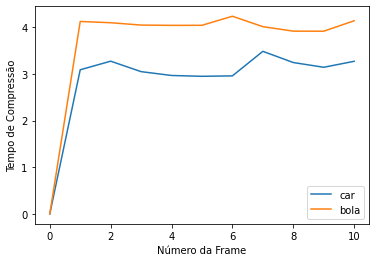

In [45]:
tc_car3 = resultado_car_3['tempo_comp']
tc_bola3 = resultado_bola_3['tempo_comp']
plt.plot( frames, tc_car3, label = 'car')
plt.plot( frames, tc_bola3, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("Tempo de Compressão")
plt.show()

- Tempo de Decompressão

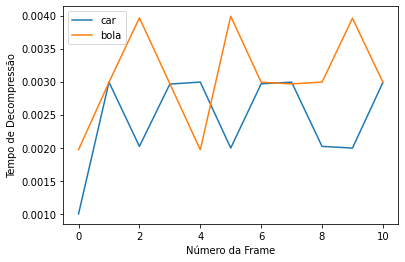

In [46]:
td_car3 = resultado_car_3['tempo_decomp']
td_bola3 = resultado_bola_3['tempo_decomp']
plt.plot( frames, td_car3, label = 'car')
plt.plot( frames, td_bola3, label = 'bola')
plt.legend()
plt.xlabel("Número da Frame")
plt.ylabel("Tempo de Decompressão")
plt.show()